In [369]:
#Data collection, save in CSV file
import tweepy
import csv
import time
from datetime import datetime
from datetime import timedelta


consumer_key = "wJvckQyRGO9j6IP1HLEqKHy2T"
consumer_secret = "vgActfGgy0UCGR5OGSGRNPiX75jIeXlNGpTtFsqStVjIY6EiIR"
access_token = "150884743-9FLqDlzvx6FFxZvhms2m4CItsFR2ANcJR4liz1HI"
access_token_secret = "Epn0ZK4uF13BMEkyIZqk7KToeXkymOl7yVG5gCNutRsFQ"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

yesterday = (datetime.now() + timedelta(days=-1)).strftime("%Y-%m-%d")
csvFile = open('IMUNISASI/imunisasi_tweet_'+yesterday+'.csv', 'a')
csvWriter = csv.writer(csvFile)
#csvWriter.writerow(["id","created_at","text","time_zone","place","coordinates","location","user_name","screen_name","retweet_count","favourite_count"])

for tweet in tweepy.Cursor(api.search,q="'imunisasi OR vaksin OR vaksinasi' -filter:retweets",count=10000,lang="id",since=yesterday,tweet_mode='extended').items():
                
    if(tweet.created_at.date() < datetime.now().date()) :
        #print (tweet.full_text.encode('unicode escape')) 
        csvWriter.writerow([tweet.id,
                            tweet.created_at,
                            tweet.full_text.encode('utf-8'),
                            tweet.user.time_zone,
                            tweet.place, 
                            tweet.coordinates,
                            tweet.user.location.encode('utf-8'),
                            tweet.user.name.encode('utf-8'),
                            tweet.user.screen_name.encode('utf-8'),
                            tweet.retweet_count,
                            tweet.favorite_count
                           ])

In [27]:
import pandas as pd
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
from googletrans import Translator
translator = Translator()

In [28]:
#MENAMBHAKAN SENTIMEN VADER
def sentiment_analyzer_scores(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text).text

    score = analyser.polarity_scores(trans)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [29]:
import seaborn as sns
def anl_tweets(lst, title='Tweets Sentiment', engl=False ): #engl = False karena pake bahasa indonesia
    sents = []
    for tw in lst:
        try:
            st = sentiment_analyzer_scores(tw, engl)
            sents.append(st)
        except:
            sents.append(0)
    ax = sns.distplot(
        sents,
        kde=False,
        bins=3)
    ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets of @"+title)
    return sents

In [206]:
#READ DATA
file_name = 'IMUNISASI/imunisasi_tweet_2019-08-19.csv'
file_name.encode()
df_tws = pd.read_csv(file_name)
df_tws.shape
df_tws.head()

,id,created_at,text,time_zone,place,coordinates,location,user_name,screen_name,retweet_count,favourite_count
0,id,created_at,text,time_zone,place,coordinates,location,user_name,screen_name,retweet_count,favourite_count
1,1163600958753923073,2019-08-19 23:57:41,b'~FEMALE SOLD\n\xe2\x9d\xa4\xef\xb8\x8f\xe2\x...,NaN,NaN,NaN,"b'Mengwi,badung,bali'",b'IWynSuranadiMuliana',b'mul_nick',0,0
2,1163600214025887745,2019-08-19 23:54:44,b'@feeqanadia Hahahaha parents refuse anak sat...,NaN,NaN,NaN,b'',b'Iqah',b'rafiqahramli',0,0
3,1163600041807765504,2019-08-19 23:54:03,b'Wei gerfren i antivax. Perlu tak aku vaksin ...,NaN,NaN,NaN,b'',b'Lucy',b'Luciferrrrrrrr',1,3
4,1163599198261936128,2019-08-19 23:50:42,b'@kangdede78 @CCICPolri @PDI_Perjuangan Nongo...,NaN,NaN,NaN,b'Jabar',b'Uto Wirdow',b'utowirdow',0,0


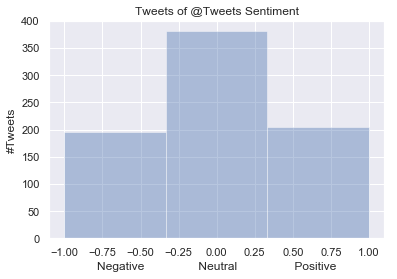

In [183]:
#ANALYZE: sentimen vader , tambah kolom sent_vader
df_tws['sent_vader'] = anl_tweets(df_tws.text)

In [316]:
#extract EMOJI
#emoji extract
def split_count(text):
    #text.decode('unicode-escape')
    emoji_list = []
    #data = regex.findall(r'\X', text)
    data = regex.findall(r'[^\x00-\x7F]+',text)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text) 
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

line = [b'Abis vaksin anjjjj gabisa tidur madep kiri ya Allah:((((( maen hp aja sakit lengannya \xf0\x9f\x98\xad AUG 27\xf0\x9f\xa6\x8b']
a=str(line[0],'utf-8')
counter = split_count(a)
emoji_all = ','.join(emoji for emoji in counter)
print(emoji_all)
print(emoji_all.encode('utf-8'))
print(counter)

😭,🦋
b'\xf0\x9f\x98\xad,\xf0\x9f\xa6\x8b'
['😭', '🦋']


In [314]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

HT_all = hashtag_extract(df_tws['text'])
#print(HT_all)
HT_all = sum(HT_all,[])
print(HT_all)

['pugloversclub', 'pugpuppies', 'pugbali', 'pugbalilover', 'hepatitisB', 'silentkiller', 'hepatitisB', 'knowtherisk', 'protectyourself', 'vaksin', 'vaksinhepatitisb', 'TangkapAbuJanda', 'Visi', 'Kesehatan', 'Imunisasi', 'Visi', 'Kesehatan', 'Imunisasi', 'Vaksin', 'Visi', 'Kesehatan', 'Imunisasi', 'Vaksin', 'hacked', 'bodohamat', 'uniklinikshahalam', 'uniklinikseksyen13', 'klinikshahalam', 'clinicshahalam', 'tekanandarah', 'diabetes', 'bloodpressuremonitoring', 'glucosemonitoring', 'homescreening', 'uniklinikdrrugaiyah', 'klinikshahalam', 'pemeriksaankesihatan', 'ultrasound', 'scanibumengandung', 'perkhidmatansunat', 'vaksin', 'KlinikDrRugaiyah', 'kaltimexpo2019', 'upsussiwab', 'kaltimberdaulat', 'Malaysia', 'children', 'malaysianow', 'news', 'DzulkeflyAhmad', 'Malay', 'Malaypolitics', 'Government', 'toddlers', 'vaccination', 'PolriUntukIndonesia74', 'StopPelanggaranStopKecelakaanKeselamatanUntukKemanusiaan', 'seriussangeneeh', 'Blog', 'HappyBlogging', 'sdmunggulindonesiamaju', 'Sahabat

In [311]:
#emoji free text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
def clean_tweets(tweet):
    
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #tweet = re.sub("""[\s"'#]+\w+""",' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)
    
    # remove twitter Return handles (RT @xxx:)
    tweet = np.vectorize(remove_pattern)(tweet, "RT @[\w]*:")
    # remove URL links (httpxxx)
    tweet = np.vectorize(remove_pattern)(tweet, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    tweet = np.core.defchararray.replace(tweet, "[^a-zA-Z#]", " ")
    # remove special characters enter \n
    tweet = np.core.defchararray.replace(tweet, "\n", " ")
    # remove special characters b'
    #tweet = np.core.defchararray.replace(tweet, "b'", "")

    return tweet

line = [b'Abis vaksin anjjjj gabisa tidur madep kiri ya Allah:((((( maen hp aja sakit lengannya \xf0\x9f\x98\xad AUG 27\xf0\x9f\xa6\x8b']
a=str(line[0],'utf-8')
print(clean_tweets(a))

Abis vaksin anjjjj gabisa tidur madep kiri ya Allah((((( maen hp aja sakit lengannya   AUG 27 


In [265]:
#DATA CLEANING, tambah kolom text_clean
df_tws['text_clean'] = clean_tweets(df_tws.text)
df_tws.head()

TypeError: cannot use a string pattern on a bytes-like object

['pugloversclub', 'pugpuppies', 'pugbali', 'pugbalilover', 'hepatitisB', 'silentkiller', 'hepatitisB', 'knowtherisk', 'protectyourself', 'vaksin', 'vaksinhepatitisb', 'TangkapAbuJanda', 'Visi', 'Kesehatan', 'Imunisasi', 'Visi', 'Kesehatan', 'Imunisasi', 'Vaksin', 'Visi', 'Kesehatan', 'Imunisasi', 'Vaksin', 'hacked', 'bodohamat', 'uniklinikshahalam', 'uniklinikseksyen13', 'klinikshahalam', 'clinicshahalam', 'tekanandarah', 'diabetes', 'bloodpressuremonitoring', 'glucosemonitoring', 'homescreening', 'uniklinikdrrugaiyah', 'klinikshahalam', 'pemeriksaankesihatan', 'ultrasound', 'scanibumengandung', 'perkhidmatansunat', 'vaksin', 'KlinikDrRugaiyah', 'kaltimexpo2019', 'upsussiwab', 'kaltimberdaulat', 'Malaysia', 'children', 'malaysianow', 'news', 'DzulkeflyAhmad', 'Malay', 'Malaypolitics', 'Government', 'toddlers', 'vaccination', 'PolriUntukIndonesia74', 'StopPelanggaranStopKecelakaanKeselamatanUntukKemanusiaan', 'seriussangeneeh', 'Blog', 'HappyBlogging', 'sdmunggulindonesiamaju', 'Sahabat

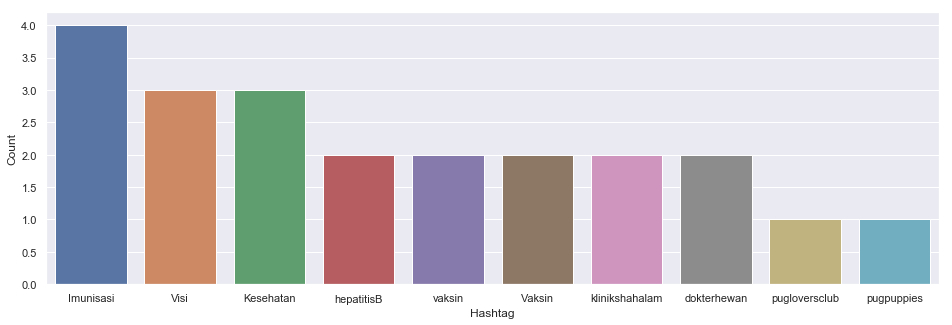

In [291]:
# collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

HT_all = hashtag_extract(df_tws['text'])
#print(HT_all)
HT_all = sum(HT_all,[])
print(HT_all)

#show bar plot
a = nltk.FreqDist(HT_all)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [23]:
#VISUALISASI
#WORD CLOUD
word_cloud(df_tws.text)
# Words in negative tweets
tws_pos = df_tws['text'][df_tws['sent_vader'] == -1]
word_cloud(tws_pos)

[]


In [324]:
#PREPROCESSING
import re
import string
import csv

file_data_normalisasi ="IMUNISASI/PREPROCESSING/normalisasi.csv"
file_data_asli ="IMUNISASI/imunisasi_tweet_2019-08-19.csv"
file_data_preprocessing ="IMUNISASI/PREPROCESSING/data_preprocessing1.csv"


from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stopwords_factory = StopWordRemoverFactory()
stopword = stopwords_factory.create_stop_word_remover()
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
reader = csv.reader(open(file_data_normalisasi, 'r')) #Sumber : Rinaldo (2016)
data_asli = csv.reader(open(file_data_asli, 'r'))
fw = open(file_data_preprocessing, 'a')

d = {}
for row in reader :
    k,v = row
    k = k.lower()
    v = v.lower()
    d[k] = v
pat = re.compile(r"\b(%s)\b" % "|".join(d))

for row in data_asli :
#===================================NORMALISASI KATA===========================
    content = list(row[i] for i in included_cols)
    print(content)
    print("Teks Asli :"+str(content))
    content = str(content).lower()
    content = pat.sub(lambda m: d.get(m.group()), content)
    print("Proses Normalisasi :"+content)
    
    '''
    pattern = '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)' #ini kode yang diubah
    text = re.sub(pattern,'',text, flags=re.MULTILINE)
    pattern = r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*'
    text = re.sub(pattern,'',text, flags=re.MULTILINE)
    remove = string.punctuation
    kd = ' '.join(word.strip(remove) for word in text.split())
    text = kd
    text = stopword.remove(text)
    text = stemmer.stem(text)
    '''
    
    fw.write(content+"\n")
fw.close()

['id', 'created_at', 'text']
Teks Asli :['id', 'created_at', 'text']
Proses Normalisasi :['id', 'created_at', 'text']


IndexError: list index out of range

In [325]:
import os
import pandas as pd

file ="IMUNISASI/imunisasi_tweet_2019-08-19.csv"
file_data_preprocessing ="IMUNISASI/PREPROCESSING/data_preprocessing1.csv"
#columns of the csv file
COLS = ['id', 'created_at', 'clean_text', 'emoticon']


# If the file exists, then read the existing data from the CSV file.
if os.path.exists(file):
    df = pd.read_csv(file, header=0)
else:
    df = pd.DataFrame(columns=COLS)

# iteration
for page in tweepy.Cursor(api.search, q=keyword,
                          count=10000, include_rts=False, since=start_date).pages(50):
    for status in page:

        new_entry = []
        status = status._json

        ## check whether the tweet is in english or skip to the next tweet
        if status['lang'] != 'in':
            continue

        #when run the code, below code replaces the retweet amount and
        #no of favorires that are changed since last download.
        if status['created_at'] in df['created_at'].values:
            i = df.loc[df['created_at'] == status['created_at']].index[0]
            if status['favorite_count'] != df.at[i, 'favorite_count'] or                        status['retweet_count'] != df.at[i, 'retweet_count']:
                df.at[i, 'favorite_count'] = status['favorite_count']
                df.at[i, 'retweet_count'] = status['retweet_count']
            continue


       #tweepy preprocessing called for basic preprocessing
        #clean_text = p.clean(status['text'])
        clean_text = status['text']

        #call clean_tweet method for extra preprocessing
        filtered_tweet=clean_tweets(clean_text)

        #pass textBlob method for sentiment calculations
        blob = TextBlob(filtered_tweet)
        Sentiment = blob.sentiment

        #seperate polarity and subjectivity in to two variables
        polarity = Sentiment.polarity
        subjectivity = Sentiment.subjectivity

        #new entry append status['text'],
        new_entry += [status['id'], status['created_at'],
                      status['source'], filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                      status['favorite_count'], status['retweet_count']]

        #to append original author of the tweet
        new_entry.append(status['user']['screen_name'])

        try:
            is_sensitive = status['possibly_sensitive']
        except KeyError:
            is_sensitive = None
        new_entry.append(is_sensitive)

        # hashtagas and mentiones are saved using comma separted
        hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
        new_entry.append(hashtags)
        mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
        new_entry.append(mentions)

        #get location of the tweet if possible
        try:
            location = status['user']['location']
        except TypeError:
            location = ''
        new_entry.append(location)

        try:
            coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
        except TypeError:
            coordinates = None
        new_entry.append(coordinates)

        #textutf8 = status['text'].encode('utf-8')
        #new_entry.append(textutf8)

        textutf8 = status['text'].encode('utf-8')
        new_entry.append(textutf8)

        #textdemojize = emoji.demojize(status['text'])
        #new_entry.append(textdemojize)

        single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
        df = df.append(single_tweet_df, ignore_index=True)
        csvFile = open(file, 'a' ,encoding='utf-8')
df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")


NameError: name 'os' is not defined

In [382]:
file ="IMUNISASI/imunisasi_tweet_2019-08-19_.csv"
df = pd.read_csv(file, delimitenames = ['id','created_at','text','time_zone','place','coordinates','location','user_name','screen_name','retweet_count','favourite_count'])

In [383]:
import os

def remove_empty_lines(filename):
    if not os.path.isfile(filename):
        print("{} does not exist ".format(filename))
        return
    with open(filename) as filehandle:
        lines = filehandle.readlines()

    with open(filename, 'w') as filehandle:
        lines = filter(lambda x: x.strip(), lines)
        filehandle.writelines(lines)   

In [384]:
file ="IMUNISASI/imunisasi_tweet_2019-08-19_.csv"
remove_empty_lines(file)

In [387]:
print(df.text)

0                                                     NaN
1       b'@feeqanadia Hahahaha parents refuse anak sat...
2       b'Wei gerfren i antivax. Perlu tak aku vaksin ...
3       b'@kangdede78 @CCICPolri @PDI_Perjuangan Nongo...
4                                                     NaN
                              ...                        
1378                                                  NaN
1379                                                  NaN
1380                                                  NaN
1381                                                  NaN
1382                                                  NaN
Name: text, Length: 1383, dtype: object


In [386]:
HT_all = hashtag_extract(df['text'])
df['hashtag']=HT_all
df

TypeError: expected string or bytes-like object

In [388]:
#line = [b'Abis vaksin anjjjj gabisa tidur madep kiri ya Allah:((((( maen hp aja sakit lengannya \xf0\x9f\x98\xad AUG 27\xf0\x9f\xa6\x8b']
# Decode dataframe in Python
 
df['text_decode'] = map(lambda x: x.decode('utf-8','strict'), df['text'])

#df['text']=str(df['text'],'utf-8')
#df['text']=df['text'].decode('utf-8')
#cl_tweet = clean_tweets(df['text_decode'])
#df['clean_text'] = cl_tweet
df

,id,created_at,text,time_zone,place,coordinates,location,user_name,screen_name,retweet_count,favourite_count,text_decode
0,"1163600958753923073,2019-08-19 23:57:41,""b'~FE...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<map object at 0x000001CDC16A9FD0>
1,1163600214025887745,2019-08-19 23:54:44,b'@feeqanadia Hahahaha parents refuse anak sat...,NaN,NaN,NaN,b'',b'Iqah',b'rafiqahramli',0,0;,<map object at 0x000001CDC16A9FD0>
2,1163600041807765504,2019-08-19 23:54:03,b'Wei gerfren i antivax. Perlu tak aku vaksin ...,NaN,NaN,NaN,b'',b'Lucy',b'Luciferrrrrrrr',1,3;,<map object at 0x000001CDC16A9FD0>
3,1163599198261936128,2019-08-19 23:50:42,b'@kangdede78 @CCICPolri @PDI_Perjuangan Nongo...,NaN,NaN,NaN,b'Jabar',b'Uto Wirdow',b'utowirdow',0,0;,<map object at 0x000001CDC16A9FD0>
4,"1163598443324964864,2019-08-19 23:47:42,""b'Yan...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<map object at 0x000001CDC16A9FD0>
5,"1163596285158367232,2019-08-19 23:39:07,b'Memb...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<map object at 0x000001CDC16A9FD0>
6,1163594755495755777,2019-08-19 23:33:02,b'@SisDaia @EsjayBhaSaya @DeeErnsxt Nama vaksi...,NaN,NaN,NaN,b'Malaysia',b'xzroluv',b'IntanKirrana1',0,0;,<map object at 0x000001CDC16A9FD0>
7,"1163593255558119424,2019-08-19 23:27:05,b'Babi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<map object at 0x000001CDC16A9FD0>
8,"1163586826549858305,2019-08-19 23:01:32,""b'@na...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<map object at 0x000001CDC16A9FD0>
9,1163585212833394688,2019-08-19 22:55:07,b'Mau vaksin kok tiba-tiba jadi pilek ya :(',NaN,NaN,NaN,b'\xf0\x9f\x93\x8dSub',b'vina',b'vinazaviranizar',0,0;,<map object at 0x000001CDC16A9FD0>
